In [1]:
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns

In [2]:
# ---- General notes ---- #

# - EUI data are at the site level
# - A site has multiple facility
# - The sum of building area of a facility doesn't seem to always total up to the reported site total area (some buildings are missing)

# ---- From org work ---- #

# Get all CBSA
df_site = pd.read_csv('../data/raw/site_details-site.csv')
df_facility = pd.read_excel('../data/raw/CBSA Public Summary Tables 6102020.xlsx', sheet_name = 'Buildings')

# Get all UrbanBEM results
df_results= pd.read_csv('../data/raw/cbsa_results_05.25.2022.csv')
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in months:
    df_results[month + '_Electricity_J'] *= 2.77778e-7
    df_results[month + '_Gas_J'] *= 9.48043e-9
    df_results = df_results.rename({month + '_Electricity_J': month + '_Electricity_kWh',
                                    month + '_Gas_J': month + '_Gas_therm'}, axis='columns')
df_results = df_results.sort_values(by = 'facility_id', ascending = True).reset_index(drop = True)

In [3]:
# Merge CBSA data
df_cbsa = pd.merge(left=df_facility, right=df_site, left_on="site_reference_number", right_on="site_reference_number")

# Compute total facility area for each site
df_cbsa['total_area_calculated'] = df_cbsa.apply(lambda row: df_cbsa.loc[df_cbsa['site_reference_number'] == row['site_reference_number']]['total_building_area'].sum(), axis=1)

In [4]:
# Identify all cases where the calculated total facility area IS DIFFERENT than the site total area
len(df_cbsa.loc[df_cbsa['total_area'] != df_cbsa['total_area_calculated'], 'site_reference_number'].unique())

604

In [5]:
# Identify all cases where the calculated total facility area IS THE SAME as the site total area
len(df_cbsa.loc[df_cbsa['total_area'] == df_cbsa['total_area_calculated'], 'site_reference_number'].unique())

145

In [6]:
# Identify cases that don't have monthly electricity data
print(len(df_cbsa.loc[df_cbsa['jan_weather_normalized_electric_eui_kwh_per_sqft'].isna()]) / len(df_cbsa))

# Keep only cases with monthly electricity data
df_cbsa_elec = df_cbsa.loc[~df_cbsa['jan_weather_normalized_electric_eui_kwh_per_sqft'].isna()]

0.5321888412017167


In [7]:
# Identify cases that don't have monthly electricity data
print(len(df_cbsa.loc[df_cbsa['jan_weather_normalized_gas_eui_therms_per_sqft'].isna()]) / len(df_cbsa))

# Keep only cases with monthly electricity data
df_cbsa_gas = df_cbsa.loc[~df_cbsa['jan_weather_normalized_gas_eui_therms_per_sqft'].isna()]

0.6040772532188842


In [8]:
# Adjust weather normalized EUI by the total_area_calculated since it's the one that's modeled (approximately) in URBAN-BEM
# Approach:
# - "actual" total_area = annual weather normalized energy use / sum( weather normalized EUI )
# - weather normalized EUI *= "actual" total_area / total_area_calculated

def adjust_weather_normalized_eui(row, col_names, key_eui, key_annual):
    eui_sum = sum([row[c_n] for c_n in col_names if f"weather_normalized_{key_eui}_per_sqft" in c_n and not "annual" in c_n])
    actual_total_area = row[f"annual_weather_normalized_{key_annual}"] / eui_sum
    for c_n in col_names:
        if f"weather_normalized_{key_eui}_per_sqft" in c_n:
            row[c_n] *= actual_total_area / row['total_area_calculated']
    return row
  
col_names = df_cbsa.columns
df_cbsa_elec = df_cbsa_elec.apply(lambda row: adjust_weather_normalized_eui(row, col_names, 'electric_eui_kwh', 'electric_kwh'), axis = 1)
df_cbsa_gas = df_cbsa_gas.apply(lambda row: adjust_weather_normalized_eui(row, col_names, 'gas_eui_therms', 'gas_therms'), axis = 1)

In [9]:
# Select a subset of columns
selected_columns = ['site_reference_number', 'facility_id'] + [c_n for c_n in df_cbsa.columns if "weather_normalized" in c_n and "_per_sqft" in c_n and not "annual" in c_n]
df_cbsa_elec_sub = df_cbsa_elec[selected_columns]
df_cbsa_gas_sub = df_cbsa_gas[selected_columns]

In [10]:
# Format columns
df_cbsa_elec_sub.columns = [c_n.replace("_weather_normalized_electric", "_elec").replace("_kwh_per_sqft", "") for c_n in df_cbsa_elec_sub.columns]
df_cbsa_gas_sub.columns = [c_n.replace("_weather_normalized_gas", "_gas").replace("_therms_per_sqft", "") for c_n in df_cbsa_elec_sub.columns]

In [11]:
# Calculate and format URBAN-BEM results
def calc_eui(row):
    for c_n in df_urban_bem.columns:
        if "kWh" in c_n or "therm" in c_n:
            row[c_n] = row[c_n] / row['total_building_area']
    return row

df_urban_bem = df_cbsa[['facility_id', 'total_building_area']].merge(df_results, on="facility_id")
df_urban_bem = df_urban_bem.apply(lambda row: calc_eui(row), axis = 1)
df_urban_bem.columns = [c_n.lower().replace("electricity_kwh", "elec_eui").replace("gas_therm", "gas_eui") for c_n in df_urban_bem.columns]

In [20]:
len(df_urban_bem)

916

In [48]:
# Merge dataframes for processing
elec_columns = ["facility_id"] + [c_n for c_n in df_urban_bem.columns if "elec" in c_n]
gas_columns = ["facility_id"] + [c_n for c_n in df_urban_bem.columns if "gas" in c_n]

df_elec = pd.merge(df_cbsa_elec_sub[elec_columns], df_urban_bem[elec_columns], on="facility_id")
df_elec.columns = [c_n.replace("_x","_cbsa").replace("_y","_urban_bem") for c_n in df_elec.columns]
df_gas = pd.merge(df_cbsa_gas_sub[gas_columns], df_urban_bem[gas_columns], on="facility_id")
df_gas.columns = [c_n.replace("_x","_cbsa").replace("_y","_urban_bem") for c_n in df_gas.columns]

Text(0.5,0,'elec_eui_cbsa')

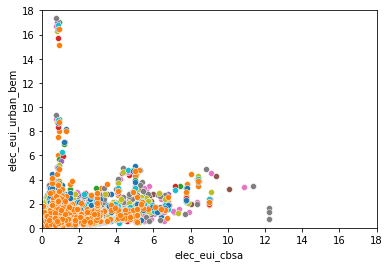

In [49]:
# Plot results
for m in months:
    c = sns.scatterplot(data=df_elec, x=f"{m.lower()}_elec_eui_cbsa", y=f"{m.lower()}_elec_eui_urban_bem")

c.set_ylim(0, 18)
c.set_xlim(0, 18)
c.set_ylabel("elec_eui_urban_bem")
c.set_xlabel("elec_eui_cbsa")

Text(0.5,0,'gas_eui_cbsa')

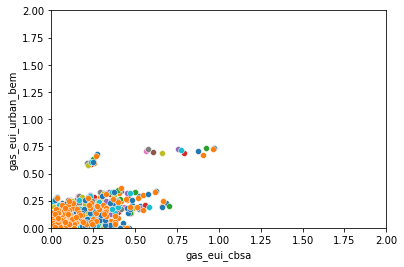

In [51]:
# Plot results
for m in months:
    c = sns.scatterplot(data=df_gas, x=f"{m.lower()}_gas_eui_cbsa", y=f"{m.lower()}_gas_eui_urban_bem")

c.set_ylim(0, 2)
c.set_xlim(0, 2)
c.set_ylabel("gas_eui_urban_bem")
c.set_xlabel("gas_eui_cbsa")